#### 1. GRIP query on TCGA-BRCA FHIR Data
Extracting breast cancer subtypes and associated patients from TCGA-BRCA FHIR transformed data

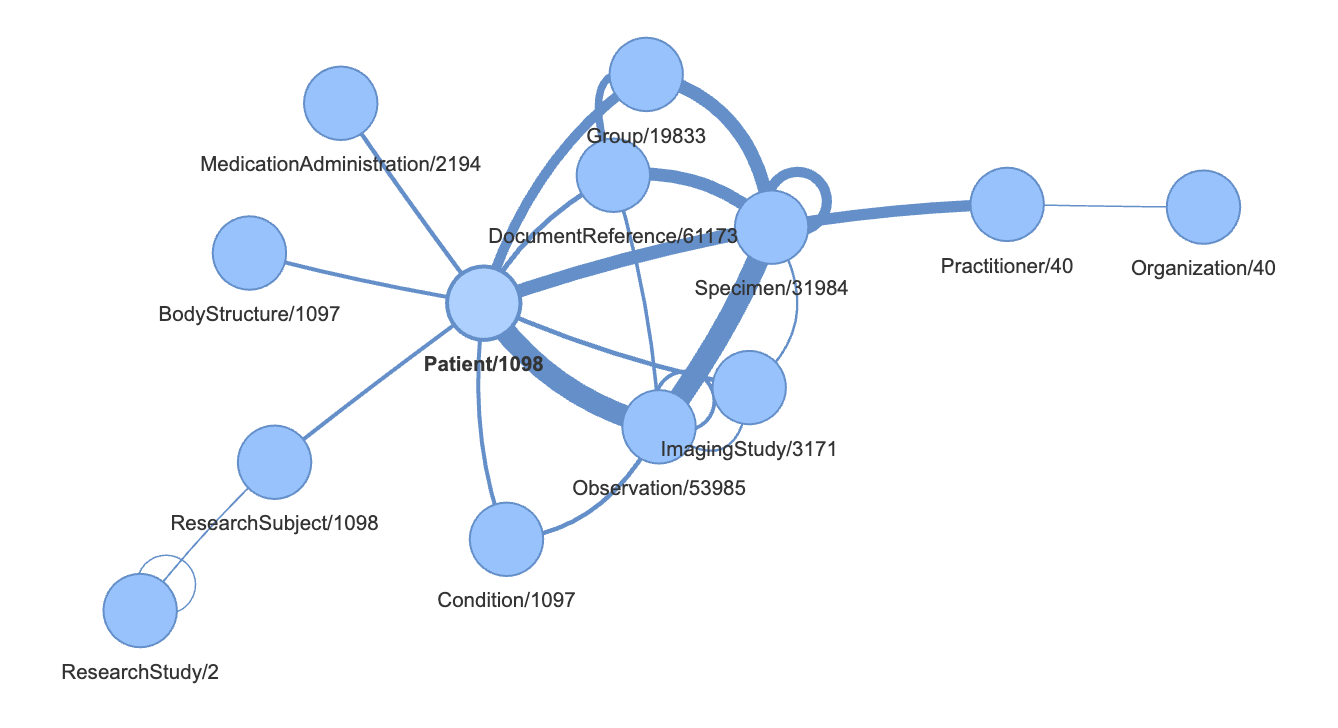

In [1]:
from IPython.display import Image
Image("../img/TCGA-BRCA-FHIRized.png", width=850) 

In [2]:
import gripql

conn = gripql.Connection("http://localhost:8201")
G = conn.graph("gdc_brca")
G.query().V().hasLabel("Patient").execute()[:1] # look at structure.

[{'gid': '28cd8c4a-2a0a-5090-8ee1-52cc2a9df946',
  'label': 'Patient',
  'data': {'deceasedBoolean': False,
   'extension': [{'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-birthsex',
     'valueCode': 'F'},
    {'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-race',
     'valueString': 'white'},
    {'url': 'http://hl7.org/fhir/us/core/StructureDefinition/us-core-ethnicity',
     'valueString': 'not hispanic or latino'},
    {'url': 'http://hl7.org/fhir/SearchParameter/patient-extensions-Patient-age',
     'valueQuantity': {'value': 58}}],
   'gender': 'female',
   'id': '28cd8c4a-2a0a-5090-8ee1-52cc2a9df946',
   'identifier': [{'system': 'https://gdc.cancer.gov/case_submitter_id',
     'use': 'secondary',
     'value': 'TCGA-BH-A0W3'},
    {'system': 'https://gdc.cancer.gov/case_id',
     'use': 'official',
     'value': '3c612e12-6de8-44fa-a095-805c45474821'}],
   'resourceType': 'Patient'}}]

In [3]:
subtypes = G.query().V().hasLabel("Observation").as_("observation").unwind("$.code").unwind("$.code.coding").has(gripql.eq("$.code.coding.code", "NCIT_C185941")).execute()
subtypes_patients = G.query().V().hasLabel("Observation").as_("observation").unwind("$.code").unwind("$.code.coding").has(gripql.eq("$.code.coding.code", "NCIT_C185941")).out("focus_Patient").execute()

In [9]:
import pandas as pd
import numpy as np 

def expand_metadata(patient_data) -> dict:
    exts = patient_data.get('extension', [])
    race = next((ext.get('valueString') for ext in exts if 'us-core-race' in ext.get('url', '')), None)
    ethnicity = next((ext.get('valueString') for ext in exts if 'us-core-ethnicity' in ext.get('url', '')), None)
    age = next((ext.get('valueQuantity', {}).get('value') for ext in exts if 'Patient-age' in ext.get('url', '')), None)
    
    idents = patient_data.get('identifier', [])
    secondary_identifier = next((iden.get('value') for iden in idents if iden.get('use') == 'secondary'), None)
    official_identifier = next((iden.get('value') for iden in idents if iden.get('use') == 'official'), None)
    
    return {
        'id': patient_data.get('id'),
        'official_identifier': official_identifier,
        'secondary_identifier': secondary_identifier,
        'gender': patient_data.get('gender'),
        'race': race,
        'ethnicity': ethnicity,
        'age': age,
        'deceased': patient_data.get('deceasedBoolean')
    }

# create a data frame for phenotypic data
df_pheno = pd.DataFrame([expand_metadata(dat['data']) for dat in subtypes_patients])
df_pheno['age'] = pd.to_numeric(df_pheno['age'], errors='coerce').fillna(0).astype(np.int64)

l = []
for item in subtypes:
    if 'valueString' in item['data'].keys():
        l.append(item['data']['valueString'])
df_pheno['subtype'] = l
df_pheno[["secondary_identifier", "subtype", "gender", "race",	"ethnicity", "age", "deceased"]]

,secondary_identifier,subtype,gender,race,ethnicity,age,deceased
0,TCGA-3C-AAAU,LumA,female,white,not hispanic or latino,55,False
1,TCGA-3C-AALI,Her2,female,black or african american,not hispanic or latino,50,False
2,TCGA-3C-AALJ,LumB,female,black or african american,not hispanic or latino,62,False
3,TCGA-3C-AALK,LumA,female,black or african american,not hispanic or latino,52,False
4,TCGA-4H-AAAK,LumA,female,white,not hispanic or latino,50,False
...,...,...,...,...,...,...,...
990,TCGA-WT-AB44,LumA,female,white,not hispanic or latino,77,False
991,TCGA-XX-A899,LumA,female,white,not hispanic or latino,46,False
992,TCGA-XX-A89A,LumA,female,white,not hispanic or latino,68,False
993,TCGA-Z7-A8R5,LumA,female,white,not hispanic or latino,61,False


In [11]:
df_pheno.to_csv("../data/brca_pheno.csv", index=False)